# Compare methods notebook

In [17]:
import glob
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import distributions
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile

In [18]:
class Result:
	def __init__(self, result_dict) -> None:
		for key in result_dict:
			setattr(self, key, result_dict[key])
		if self.method == "ptmcmc":
			burn_in_idx = self.algo_specific_info["burn_in_idx"]
			n_chains = self.n_chains
			#print(f"{burn_in_idx}, \t{n_chains}")
			self.n_fun_calls = (burn_in_idx+1)*n_chains

	def get_sampling_ratio(self, par_bounds, par_idx=0) -> float:
		"""
		Measures the ratio of the sampling space 
		explored for a given parameter index
		"""
		bound_diff = par_bounds[par_idx][1] - par_bounds[par_idx][0]
		par_samples = self.all_samples[:, :, par_idx]
		max_val = np.max(par_samples)
		min_val = np.min(par_samples)
		sample_diff = max_val - min_val
		return sample_diff/bound_diff
	
	def get_convergence(self, llh_threshold):
		idxs = np.where(self.all_llhs > llh_threshold)
		first_iter = np.min(idxs[0])

		if self.method == "ptmcmc":
			#print(self.all_llhs.shape, self.all_llhs[5:,0], idxs)
			# ! TO DO: replace this with a more exact calculation
			#print(first_iter)
			conv_calls = first_iter * self.n_chains
		else:
			conv_calls = self.algo_specific_info["calls_by_iter"][first_iter]
		return conv_calls

class MethodResults:
	def __init__(self, method) -> None:
		self.all_runs = []
		self.method = method
		if method == "pmc":
			self.abbr = "PMC"
			self.label = "Preconditioned Monte Carlo"
		elif method == "smc":
			self.abbr = "SMC"
			self.label = "Sequential Monte Carlo"
		elif method == "ptmcmc":
			self.abbr = "PT-MCMC"
			self.label = "Parallel Tempering MCMC"
	
	def add_result(self, result_obj):
		self.all_runs.append(result_obj)

	def get_fun_calls(self) -> np.array:
		all_calls = [x.n_fun_calls for x in self.all_runs]
		return np.array(all_calls)
	
	def get_llhs(self) -> np.array:
		all_llhs = [x.posterior_llhs for x in self.all_runs]
		return np.array(all_llhs)
	
	def get_sampling_efficiency(self, bounds, par_idx) -> np.array:
		all_ratios = [x.get_sampling_ratio(bounds, par_idx) for x in self.all_runs]
		return np.array(all_ratios)
	
	def get_convergence_times(self, llh_threshold):
		all_convs = [x.get_convergence(llh_threshold) for x in self.all_runs]
		return np.array(all_convs)
	
	# Source: https://stackoverflow.com/questions/40044375/how-to-calculate-the-kolmogorov-smirnov-statistic-between-two-weighted-samples
	def ks_weighted(self, data1, data2, wei1, wei2, alternative='two-sided'):
		ix1 = np.argsort(data1)
		ix2 = np.argsort(data2)
		data1 = data1[ix1]
		data2 = data2[ix2]
		wei1 = wei1[ix1]
		wei2 = wei2[ix2]
		data = np.concatenate([data1, data2])
		cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
		cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
		cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
		cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
		d = np.max(np.abs(cdf1we - cdf2we))
		# calculate p-value
		n1 = data1.shape[0]
		n2 = data2.shape[0]
		m, n = sorted([float(n1), float(n2)], reverse=True)
		en = m * n / (m + n)
		if alternative == 'two-sided':
			prob = distributions.kstwo.sf(d, np.round(en))
		else:
			z = np.sqrt(en) * d
			# Use Hodges' suggested approximation Eqn 5.3
			# Requires m to be the larger of (n1, n2)
			expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
			prob = np.exp(expt)
		return d, prob
	
	def calc_pairwise_matrix(self, par_index):
		n_runs = len(self.all_runs)
		combos = itertools.combinations(range(n_runs), 2)
		ks_matrix = np.zeros(shape=(n_runs, n_runs))
		pval_matrix = np.zeros(shape=(n_runs, n_runs))
		for i, j in combos:
			runA = self.all_runs[i]
			runB = self.all_runs[j]
			
			param_samplesA = runA.posterior_samples[:, par_index]
			param_samplesB = runB.posterior_samples[:, par_index]
			ks_stat, pval = self.ks_weighted(param_samplesA, param_samplesB,
											runA.posterior_weights, runB.posterior_weights)
			ks_matrix[j, i] = ks_stat
			ks_matrix[i, j] = ks_stat
			pval_matrix[j, i] = pval
			pval_matrix[i, j] = pval
		return ks_matrix, pval_matrix

In [19]:
prob_name = "Michaelis_Menten"
methods = ["smc", "pmc"]#, "ptmcmc"]

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		#print(fname)
		with open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
print(type(mod_prob.problem))		

<class 'pypesto.problem.base.Problem'>


<Axes: xlabel='Param', ylabel='KS'>

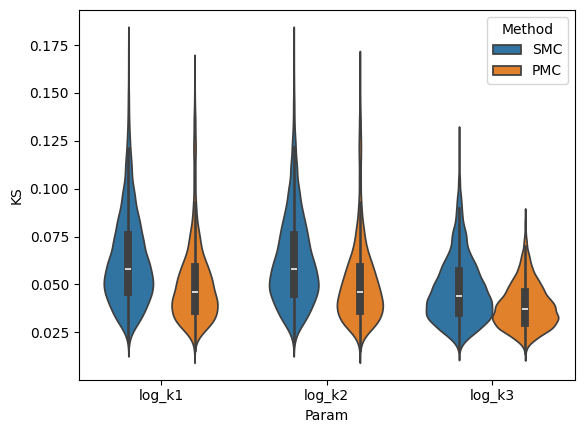

In [20]:
fit_par_names = mod_prob.problem.x_names
all_ks_stats=[]

ks_df = pd.DataFrame(columns=["Param", "Method", "KS"])
for i, name in enumerate(fit_par_names):
	# assumes all runs have the same model parameters
	for runs in grouped_results:
		ks_stats , pvals = runs.calc_pairwise_matrix(par_index=i)
		all_ks_stats.append(ks_stats[np.triu_indices(ks_stats.shape[0], k = 1)])
		for run_ks in ks_stats:
			for ks_stat in run_ks:
				new_row = {"Param":name, "Method":runs.abbr, "KS":ks_stat}
				ks_df.loc[len(ks_df)] = new_row

ks_df = ks_df.drop(ks_df[ks_df["KS"] == 0].index)

sns.violinplot(data=ks_df, x="Param", y="KS", hue="Method")

MAX NUM FUNC CALLS: 1082000


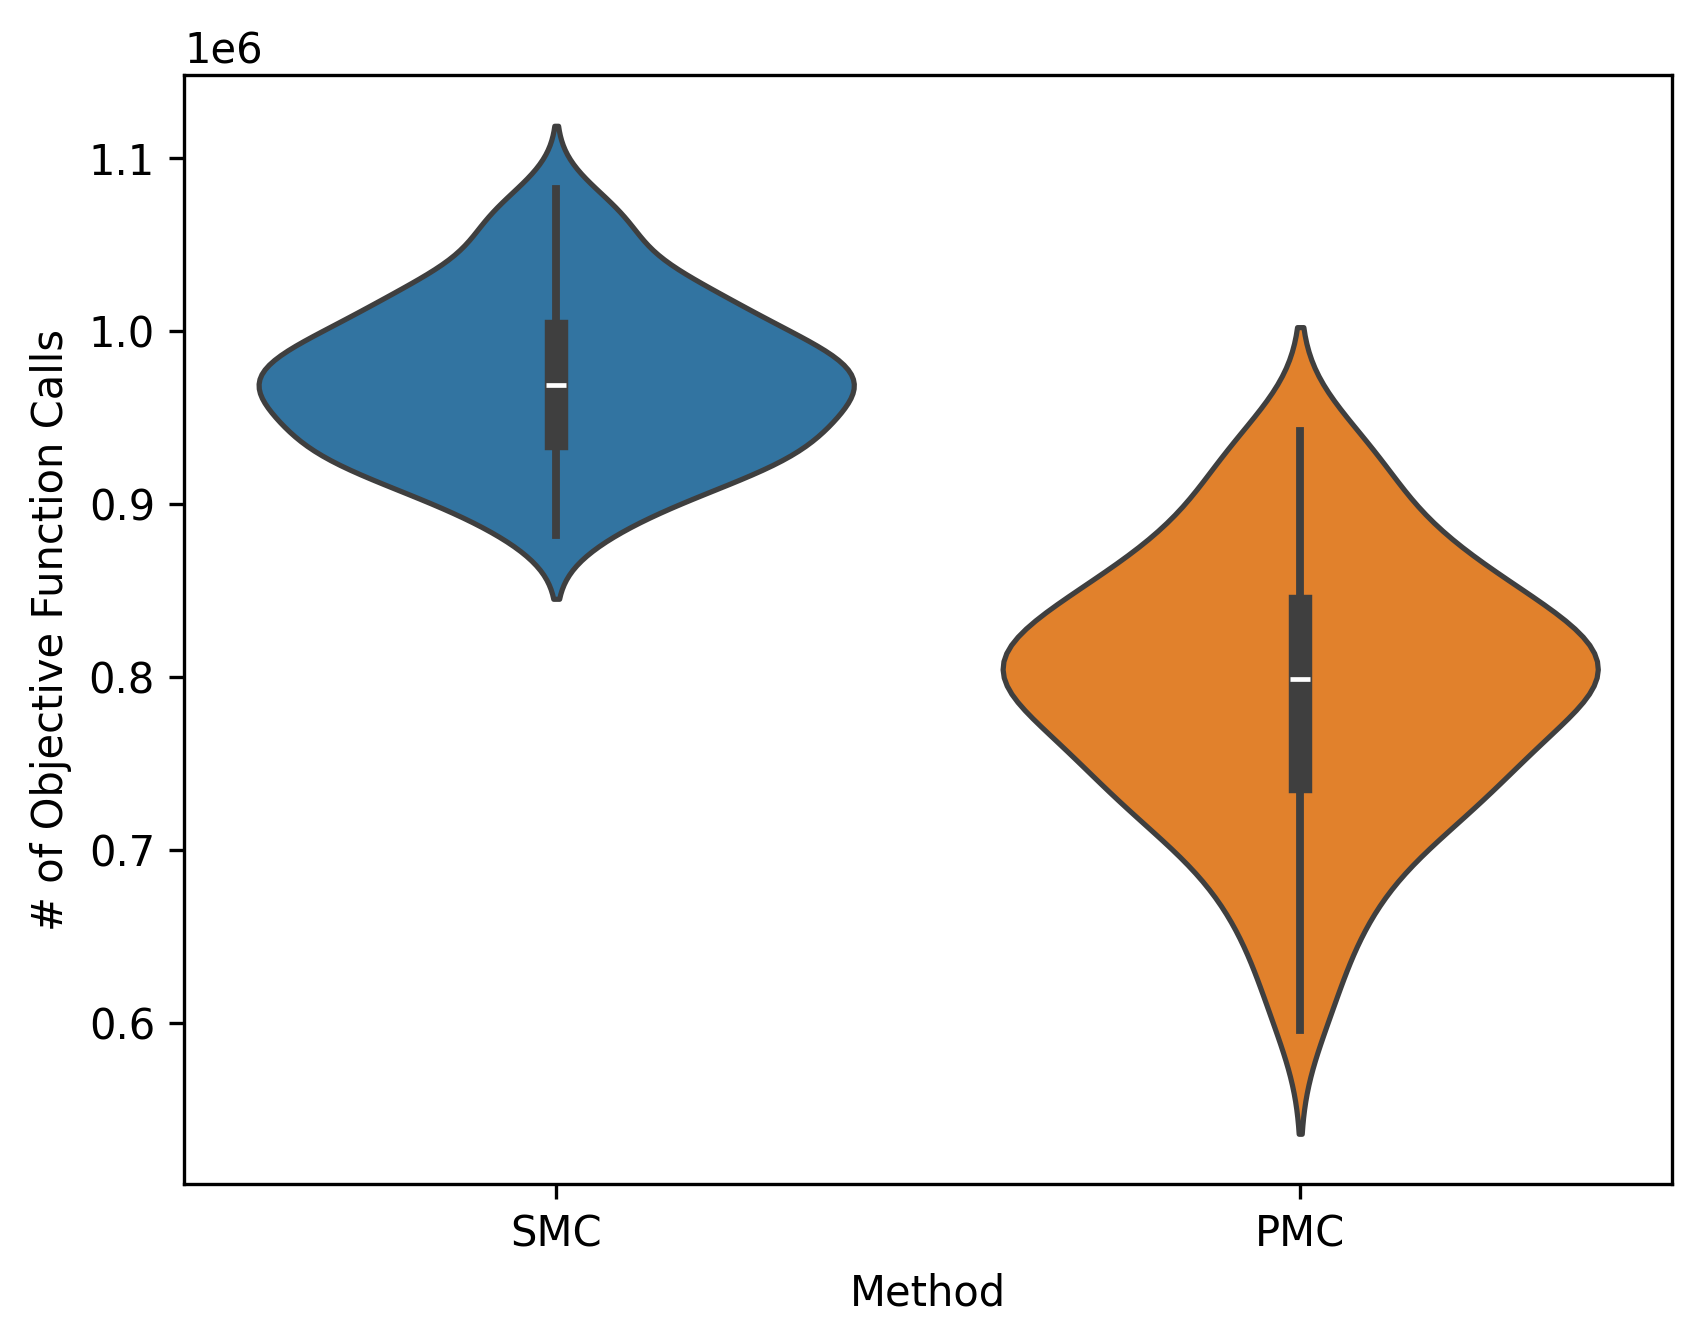

In [21]:
plt.figure(dpi=300)
calls = np.array([x.get_fun_calls() for x in grouped_results])
call_df = pd.DataFrame(columns=methods, data=calls.T)
sns.violinplot(call_df)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("# of Objective Function Calls");
print(f"MAX NUM FUNC CALLS: {np.max(calls)}")

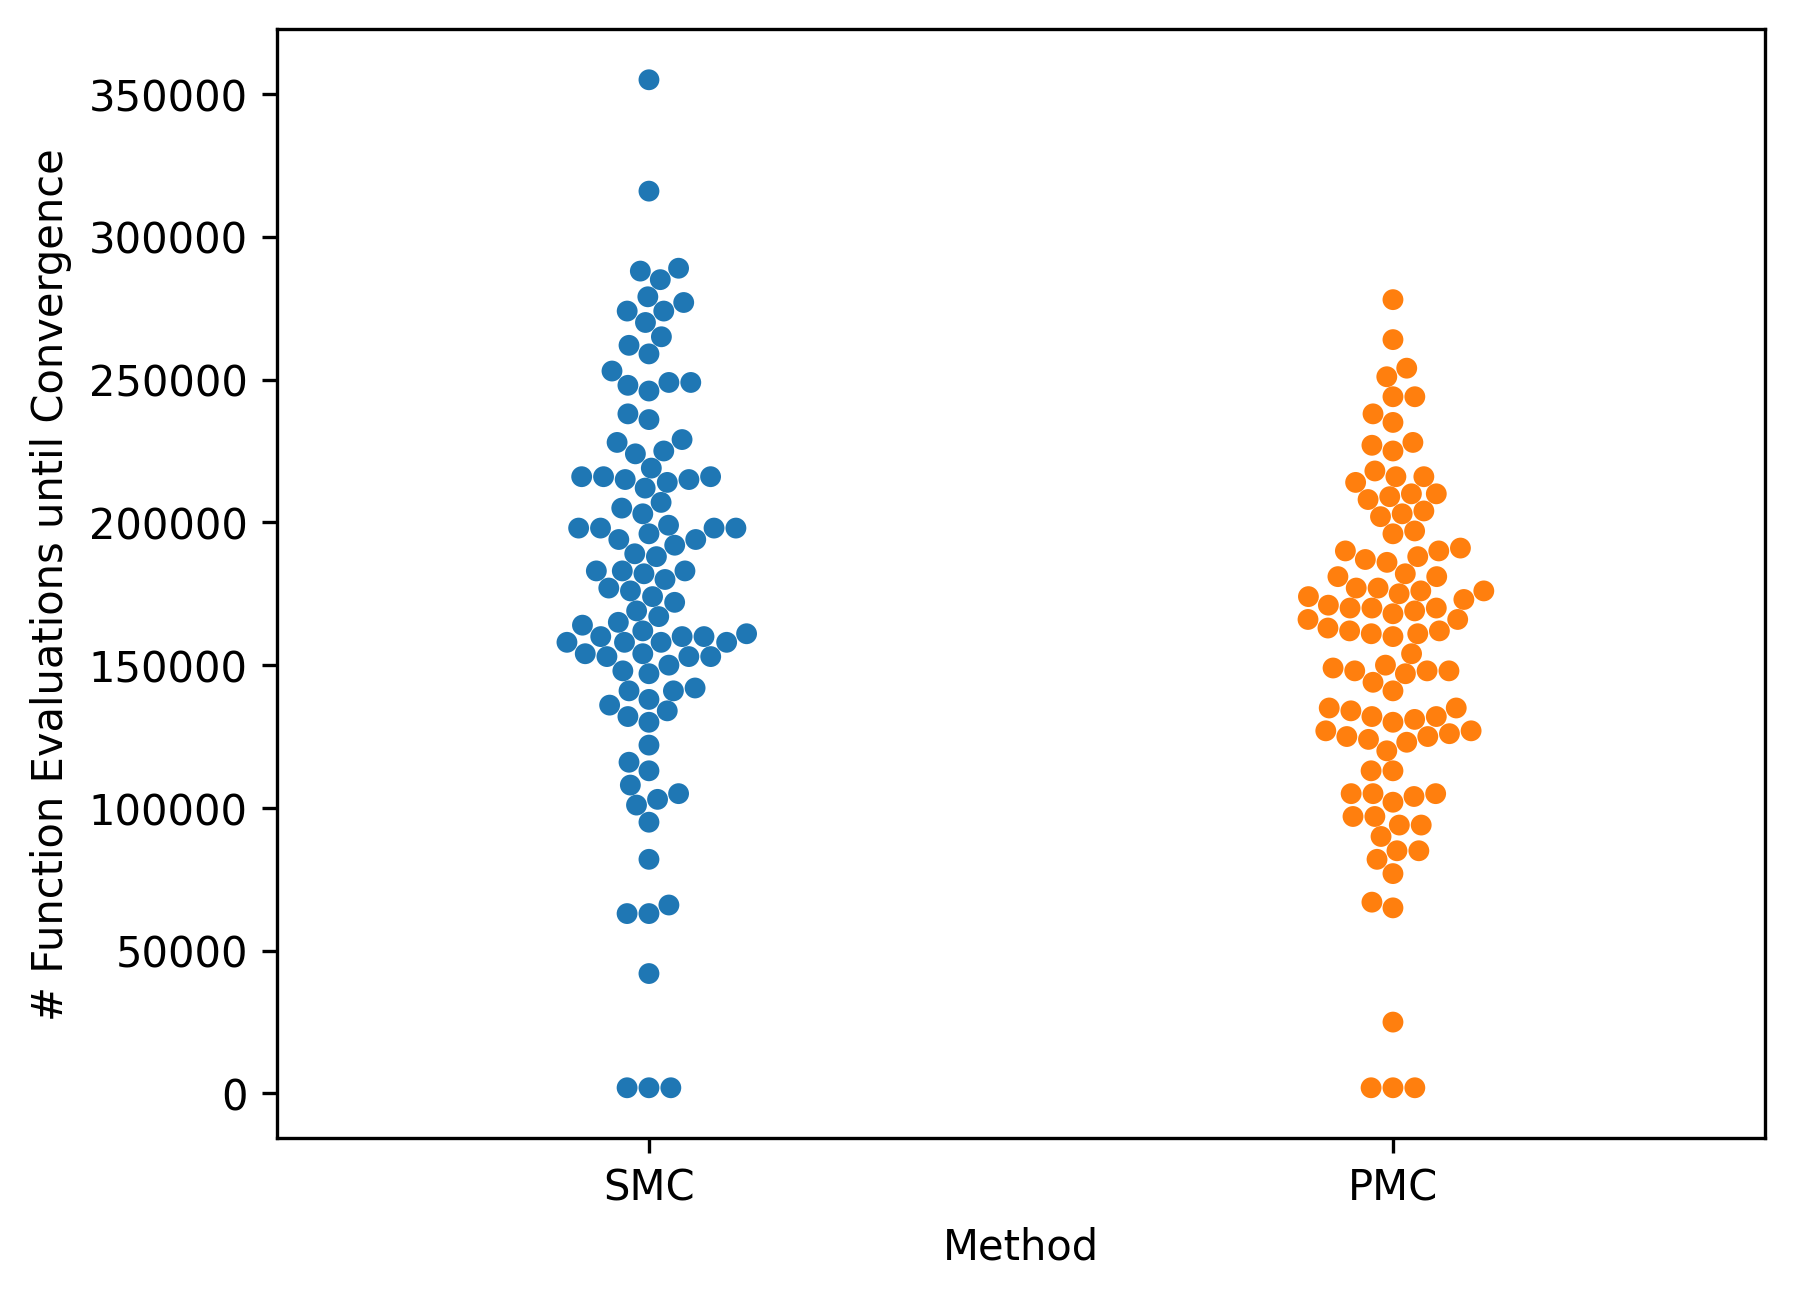

In [22]:
llh_threshold = -170
plt.figure(dpi=300)
#grouped_results[0].get_convergence_times(llh_threshold)
conv = np.array([x.get_convergence_times(llh_threshold) for x in grouped_results])
conv_df = pd.DataFrame(columns=methods, data=conv.T)

sns.swarmplot(conv_df)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); 
plt.ylabel(f"# Function Evaluations until Convergence");

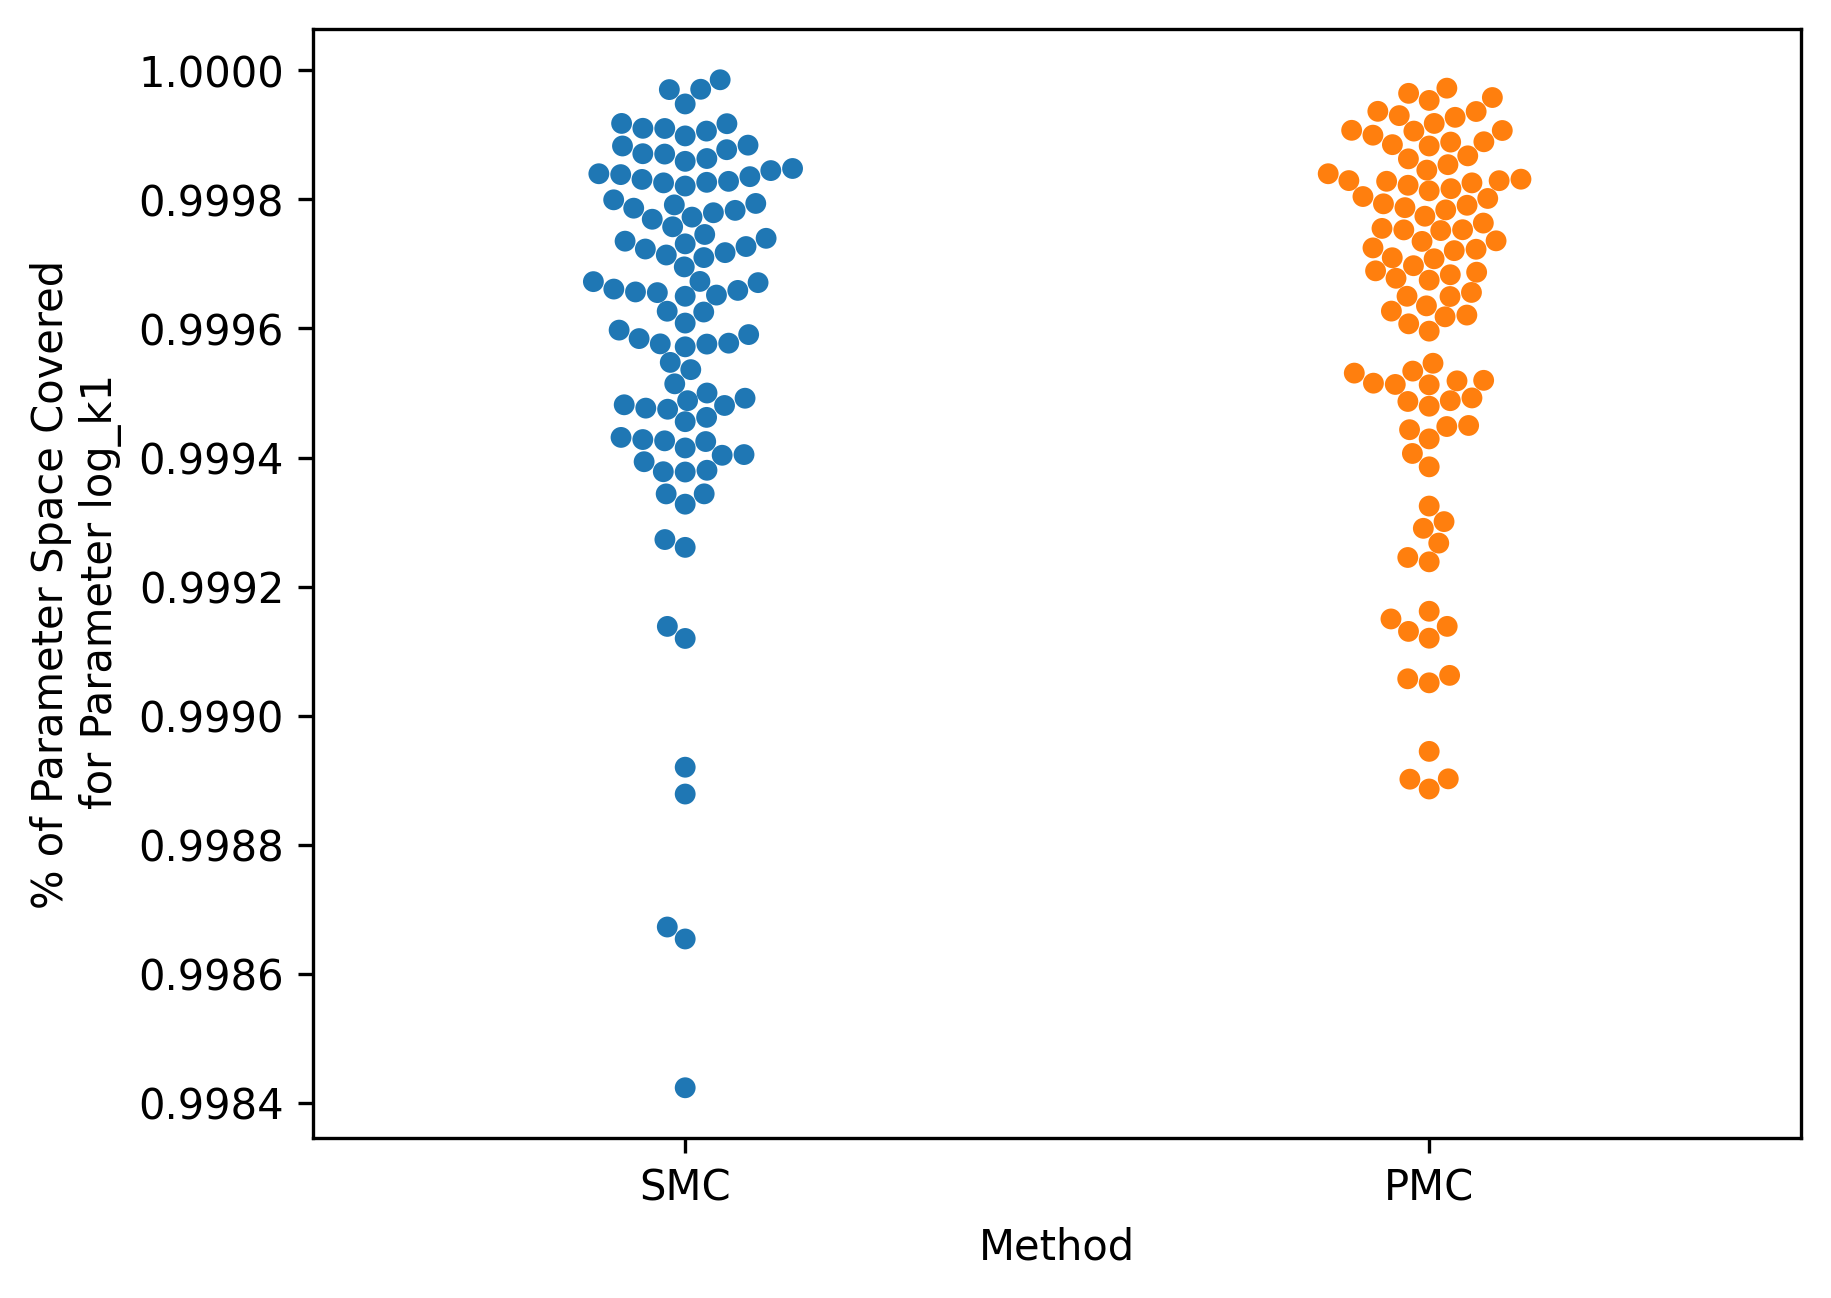

In [23]:
# Get the names of the estimated parameters
fit_par_names = mod_prob.problem.x_names
par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, 0) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)

sns.swarmplot(ratio_df)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[0]} ");

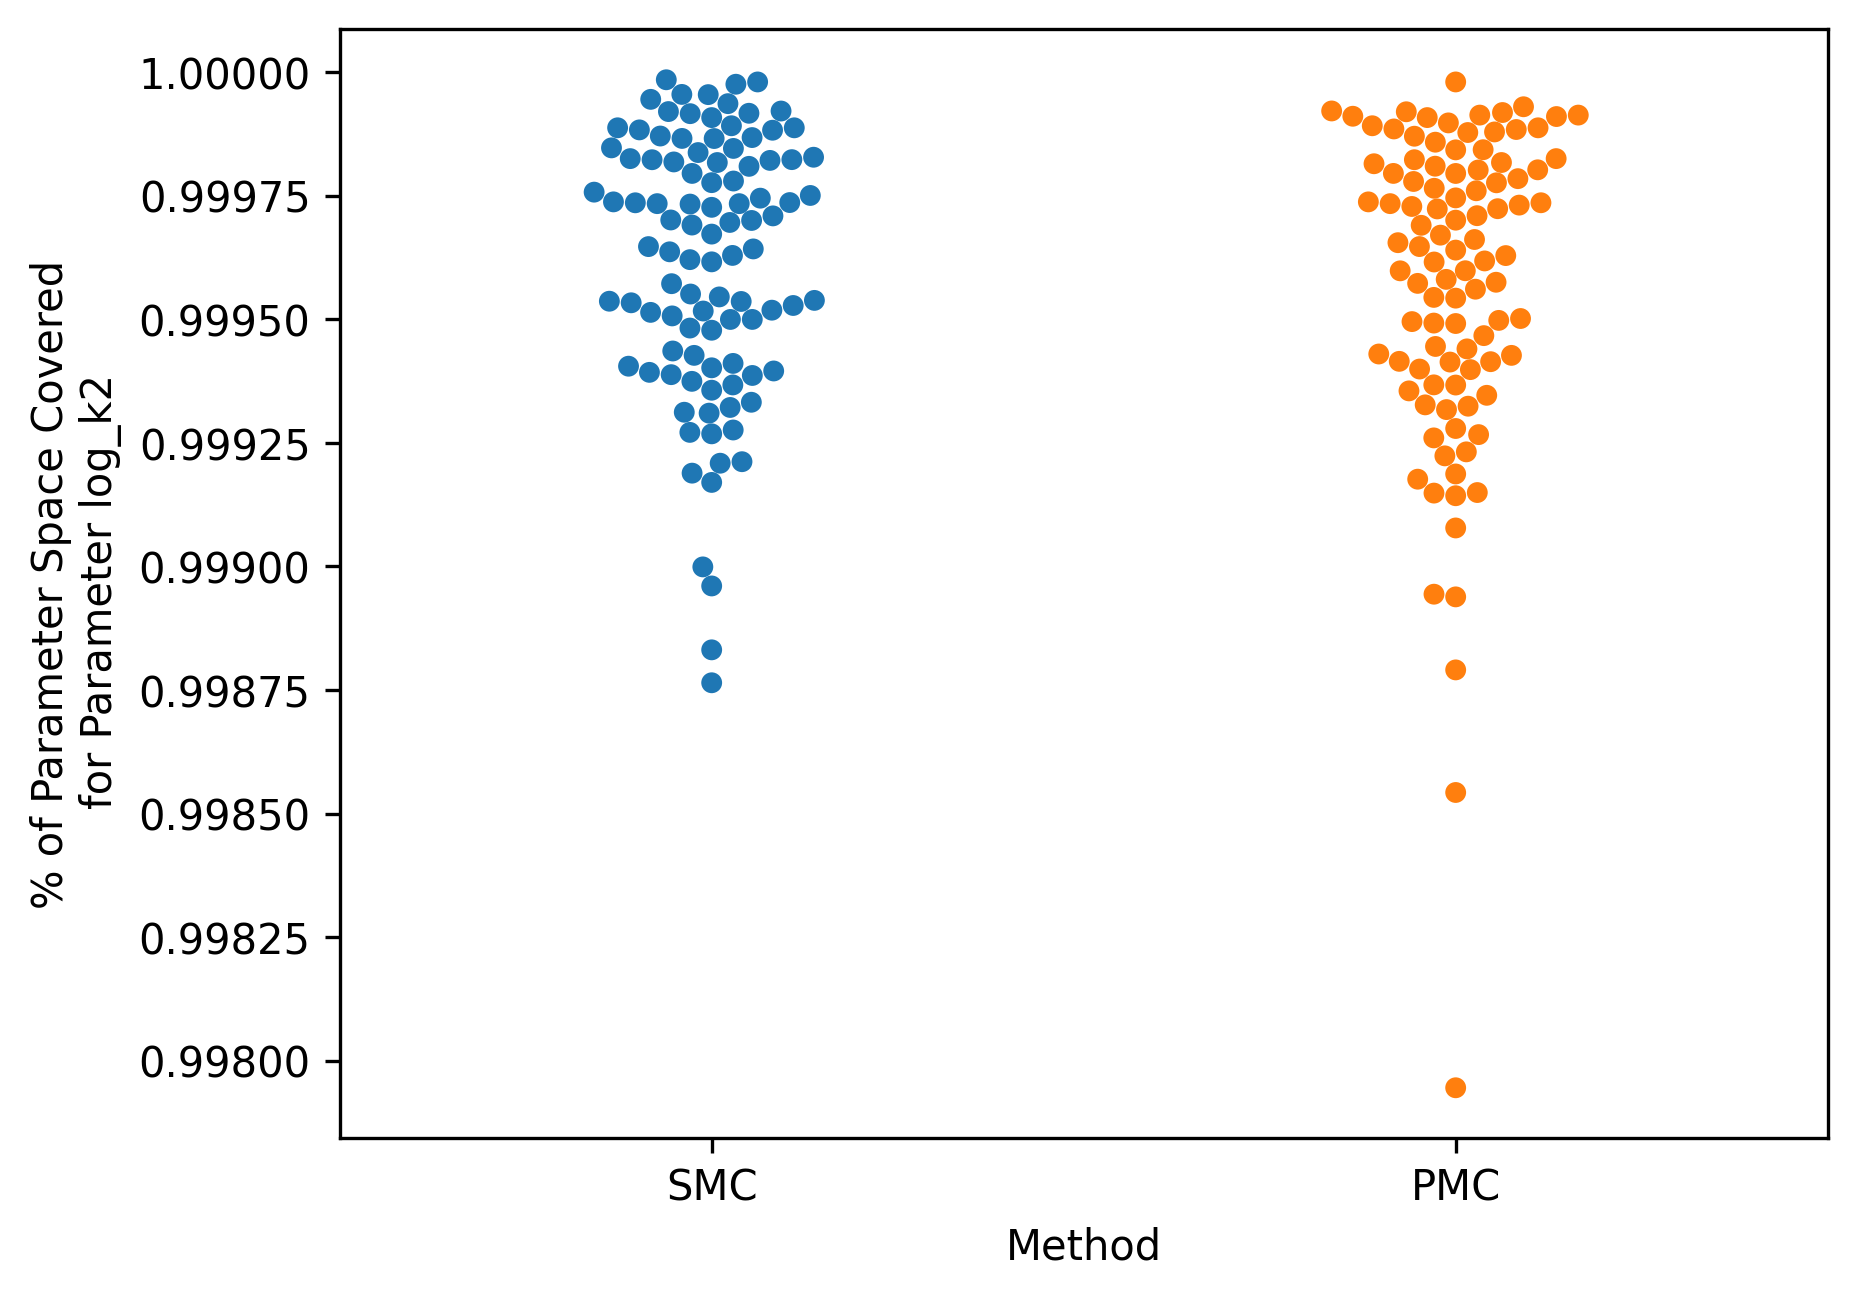

In [24]:
# Get the names of the estimated parameters
fit_par_names = mod_prob.problem.x_names
par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, 1) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)

sns.swarmplot(ratio_df)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[1]} ");

## Select best result for each method

In [25]:
llhs = np.array([x.get_llhs() for x in grouped_results])
best_runs = [np.argmax(np.max(x, axis=1)) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

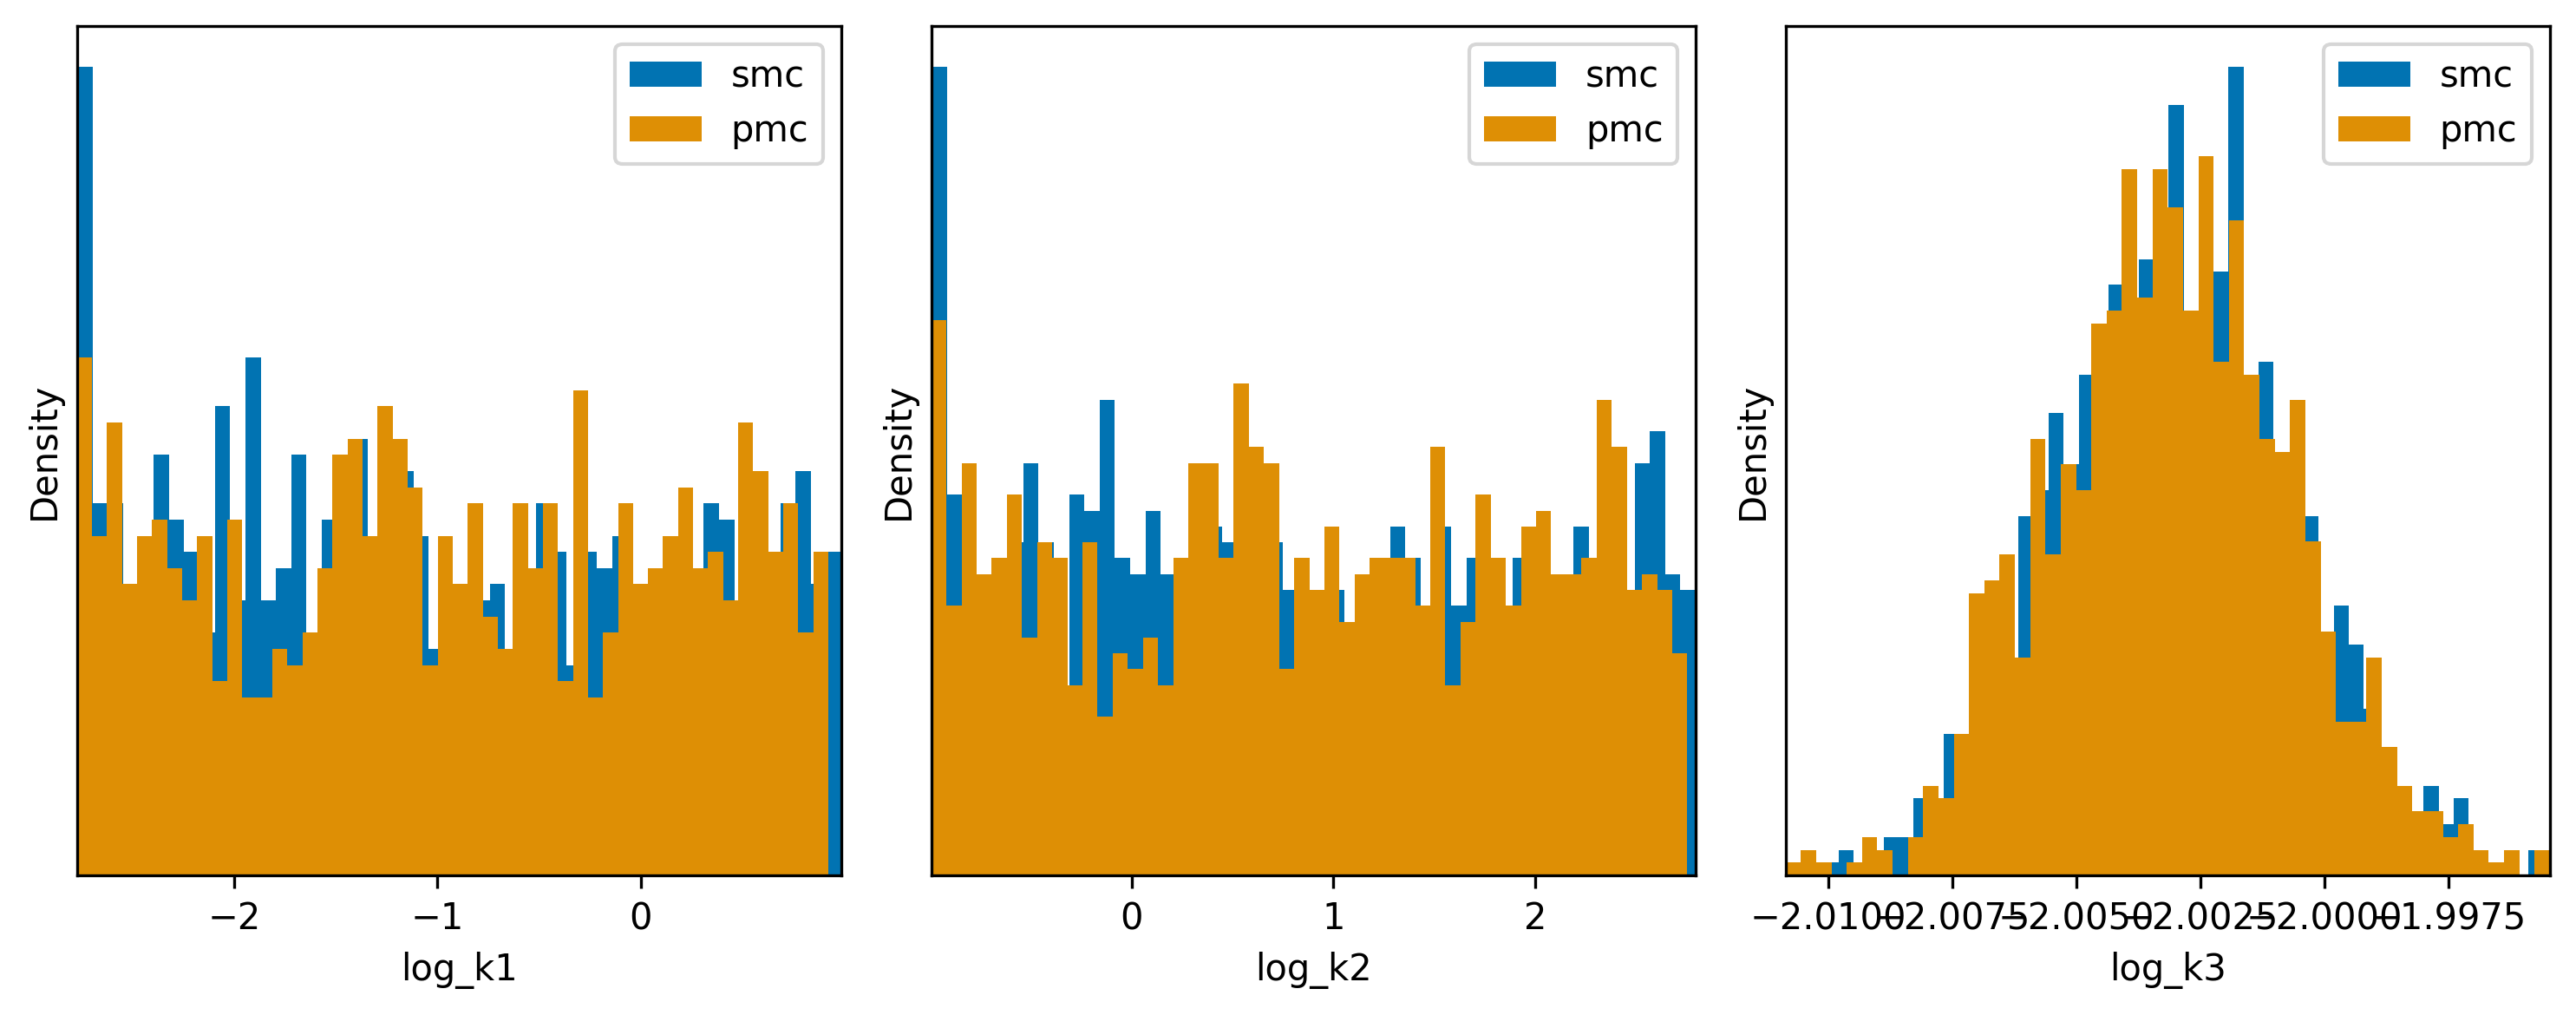

In [26]:
fit_par_names = mod_prob.problem.x_names
par_bounds = mod_prob.bounds
colors = sns.color_palette("colorblind", len(best_results))
histtype = "step"
alpha=1

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=False, histtype="bar", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

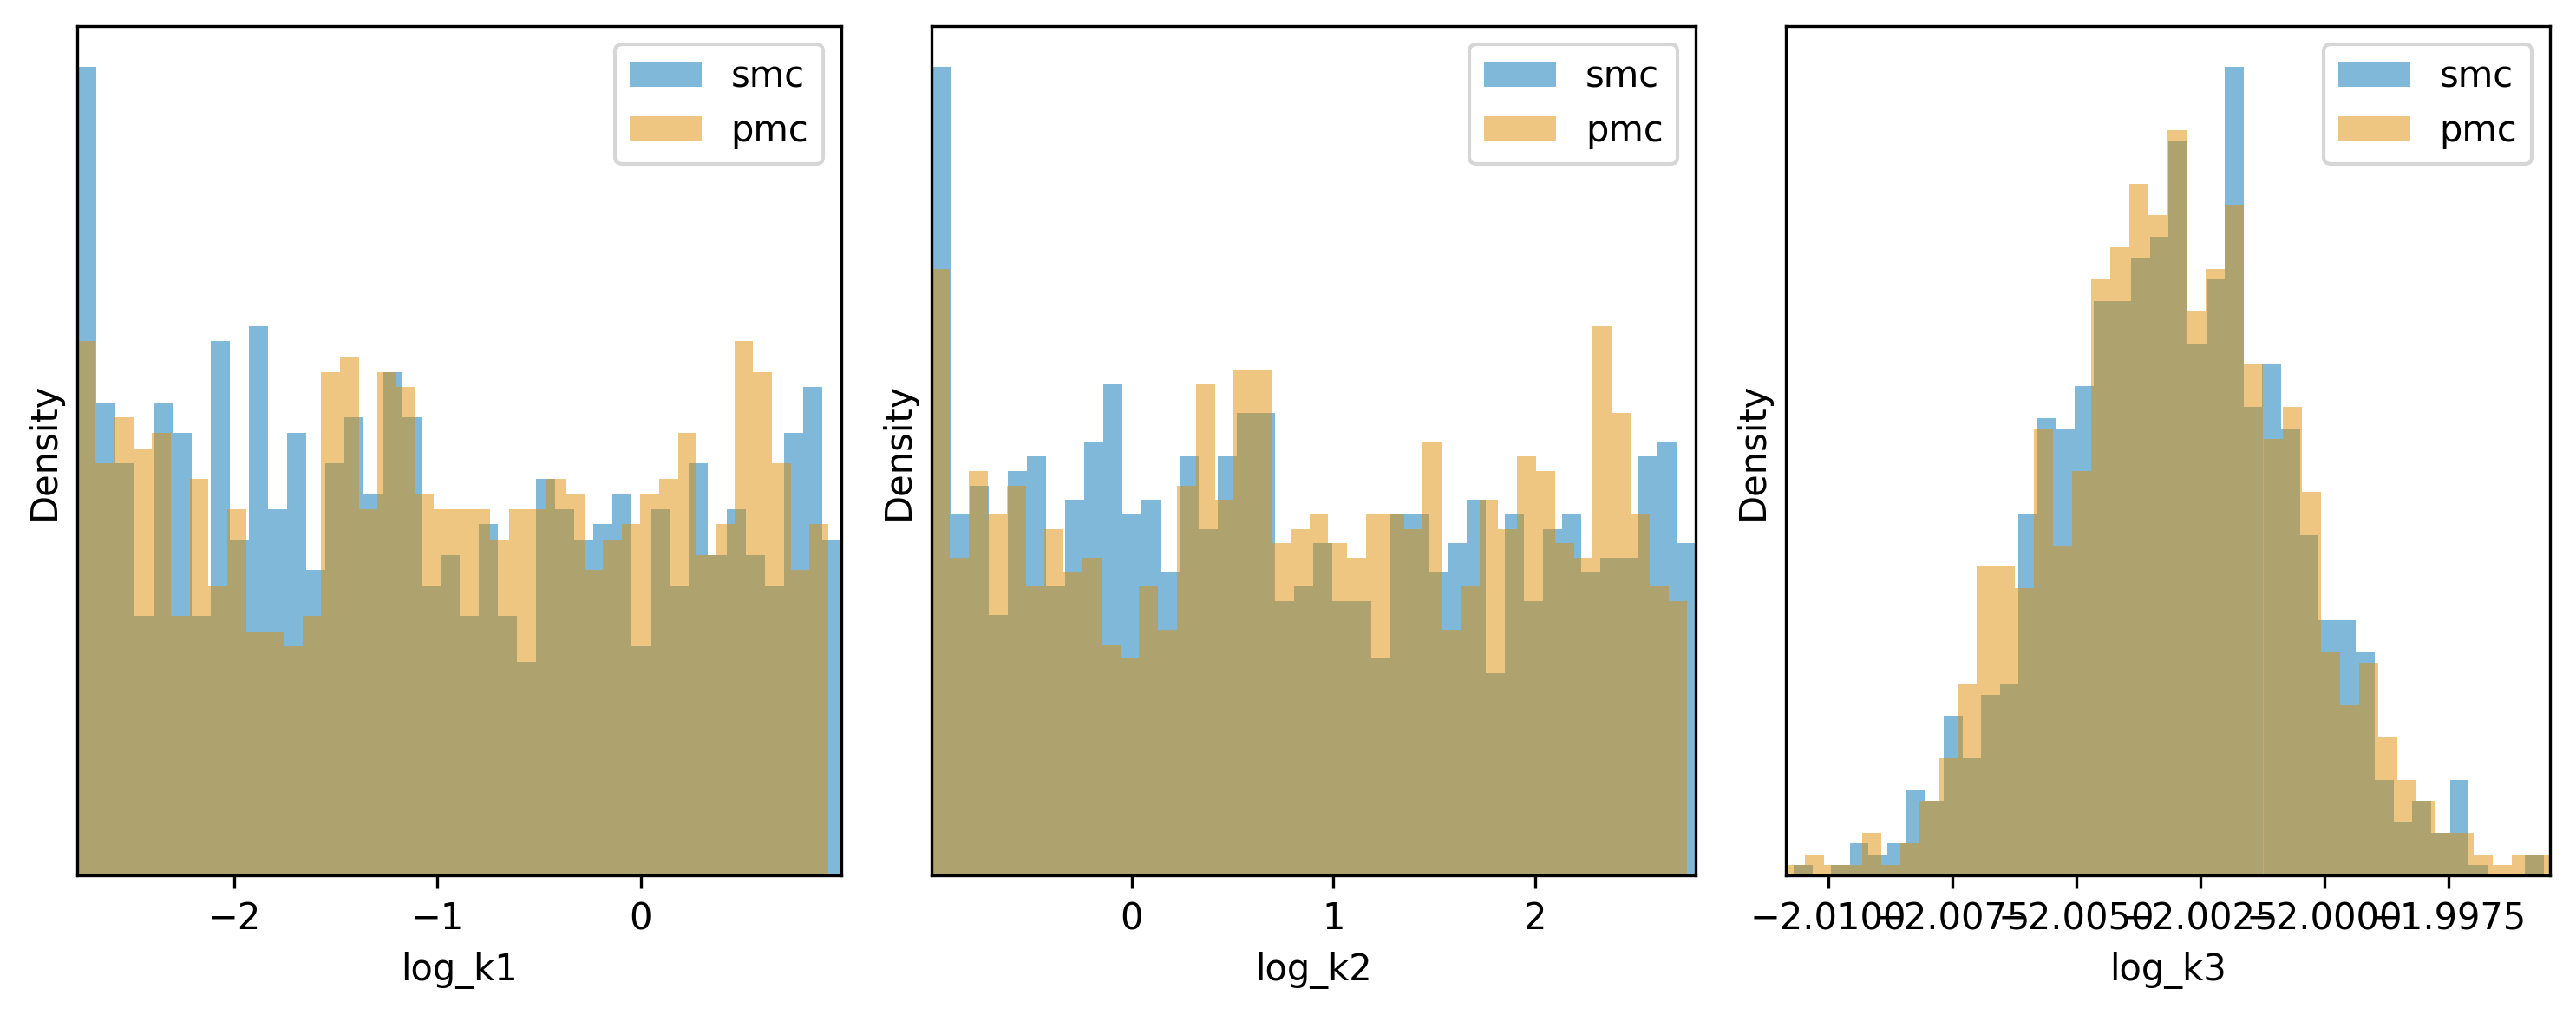

In [27]:
# Get the names of the estimated parameters
fit_par_names = mod_prob.problem.x_names
par_bounds = mod_prob.bounds
colors = sns.color_palette("colorblind", len(best_results))
histtype = "bar"
alpha=0.5

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

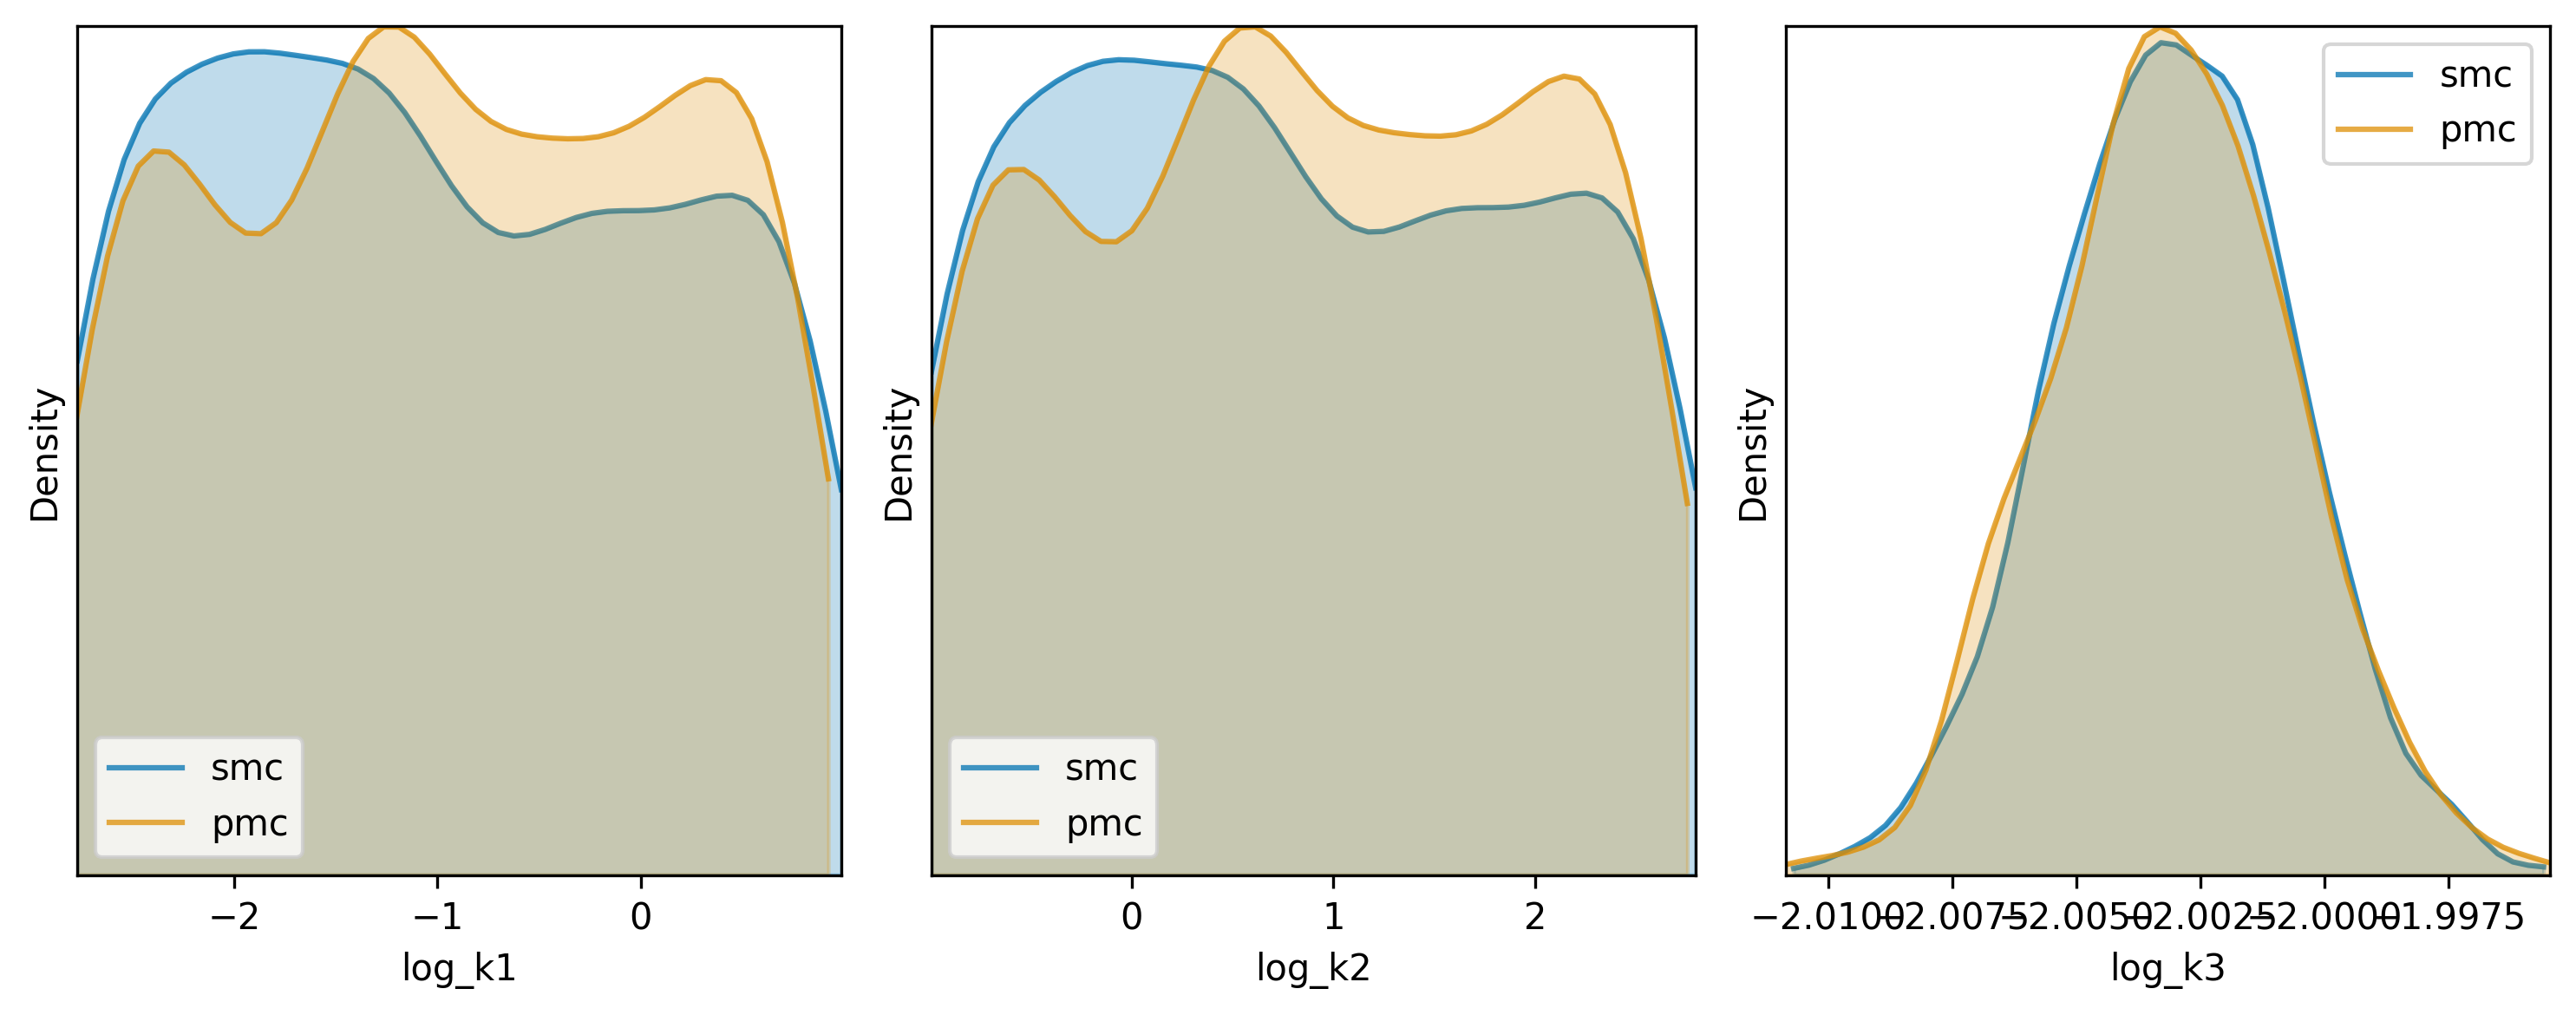

In [28]:
import scipy.stats as st
# Get the names of the estimated parameters
fit_par_names = mod_prob.problem.x_names
par_bounds = mod_prob.bounds
colors = sns.color_palette("colorblind", len(best_results))
histtype = "bar"
alpha=0.5

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		param_samples = cur_result.posterior_samples[:, i]
		norm_ws = cur_result.posterior_weights
		kde = st.gaussian_kde(param_samples, weights=norm_ws)
		x = np.linspace(np.min(param_samples), np.max(param_samples), 50)
		plt.plot(x, kde(x), '-', color=colors[j], alpha=0.75, zorder=1, label=cur_result.method)
		plt.fill_between(x, kde(x), alpha=0.25, color=colors[j], zorder=1)
		
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0, y=0.001)
	plt.legend()
plt.tight_layout()

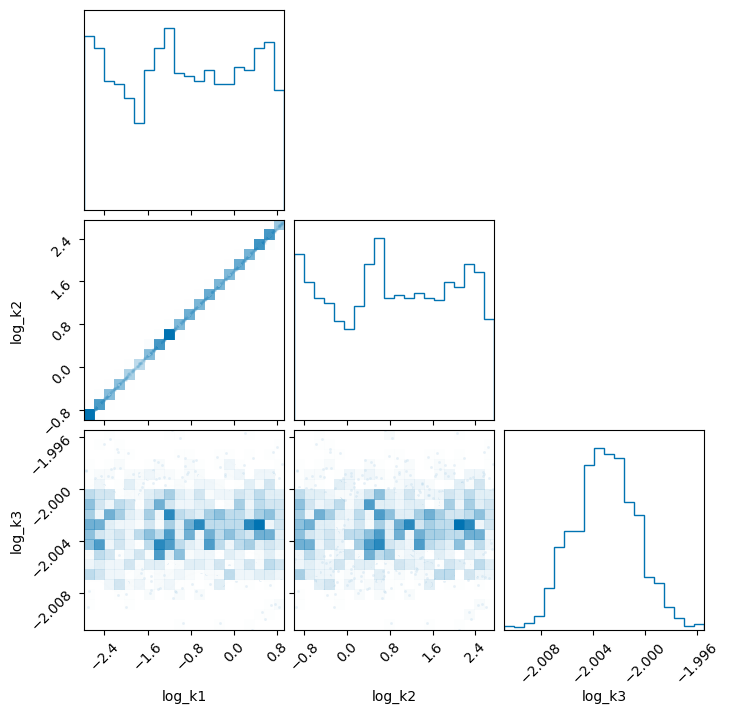

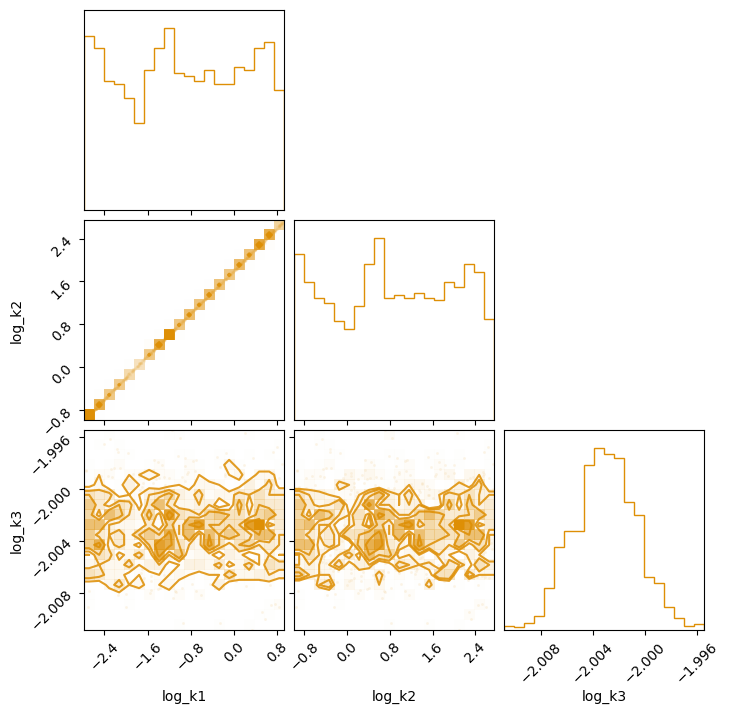

In [29]:
import corner
colors = sns.color_palette("colorblind", len(best_results))
for i, method in enumerate(methods):
	cur_result = best_results[j]
	param_samples = cur_result.posterior_samples
	norm_ws = cur_result.posterior_weights #np.divide(cur_result.posterior_weights, np.sum(cur_result.posterior_weights))
	corner.corner(param_samples, weights=norm_ws, color=colors[i], labels=fit_par_names)
	

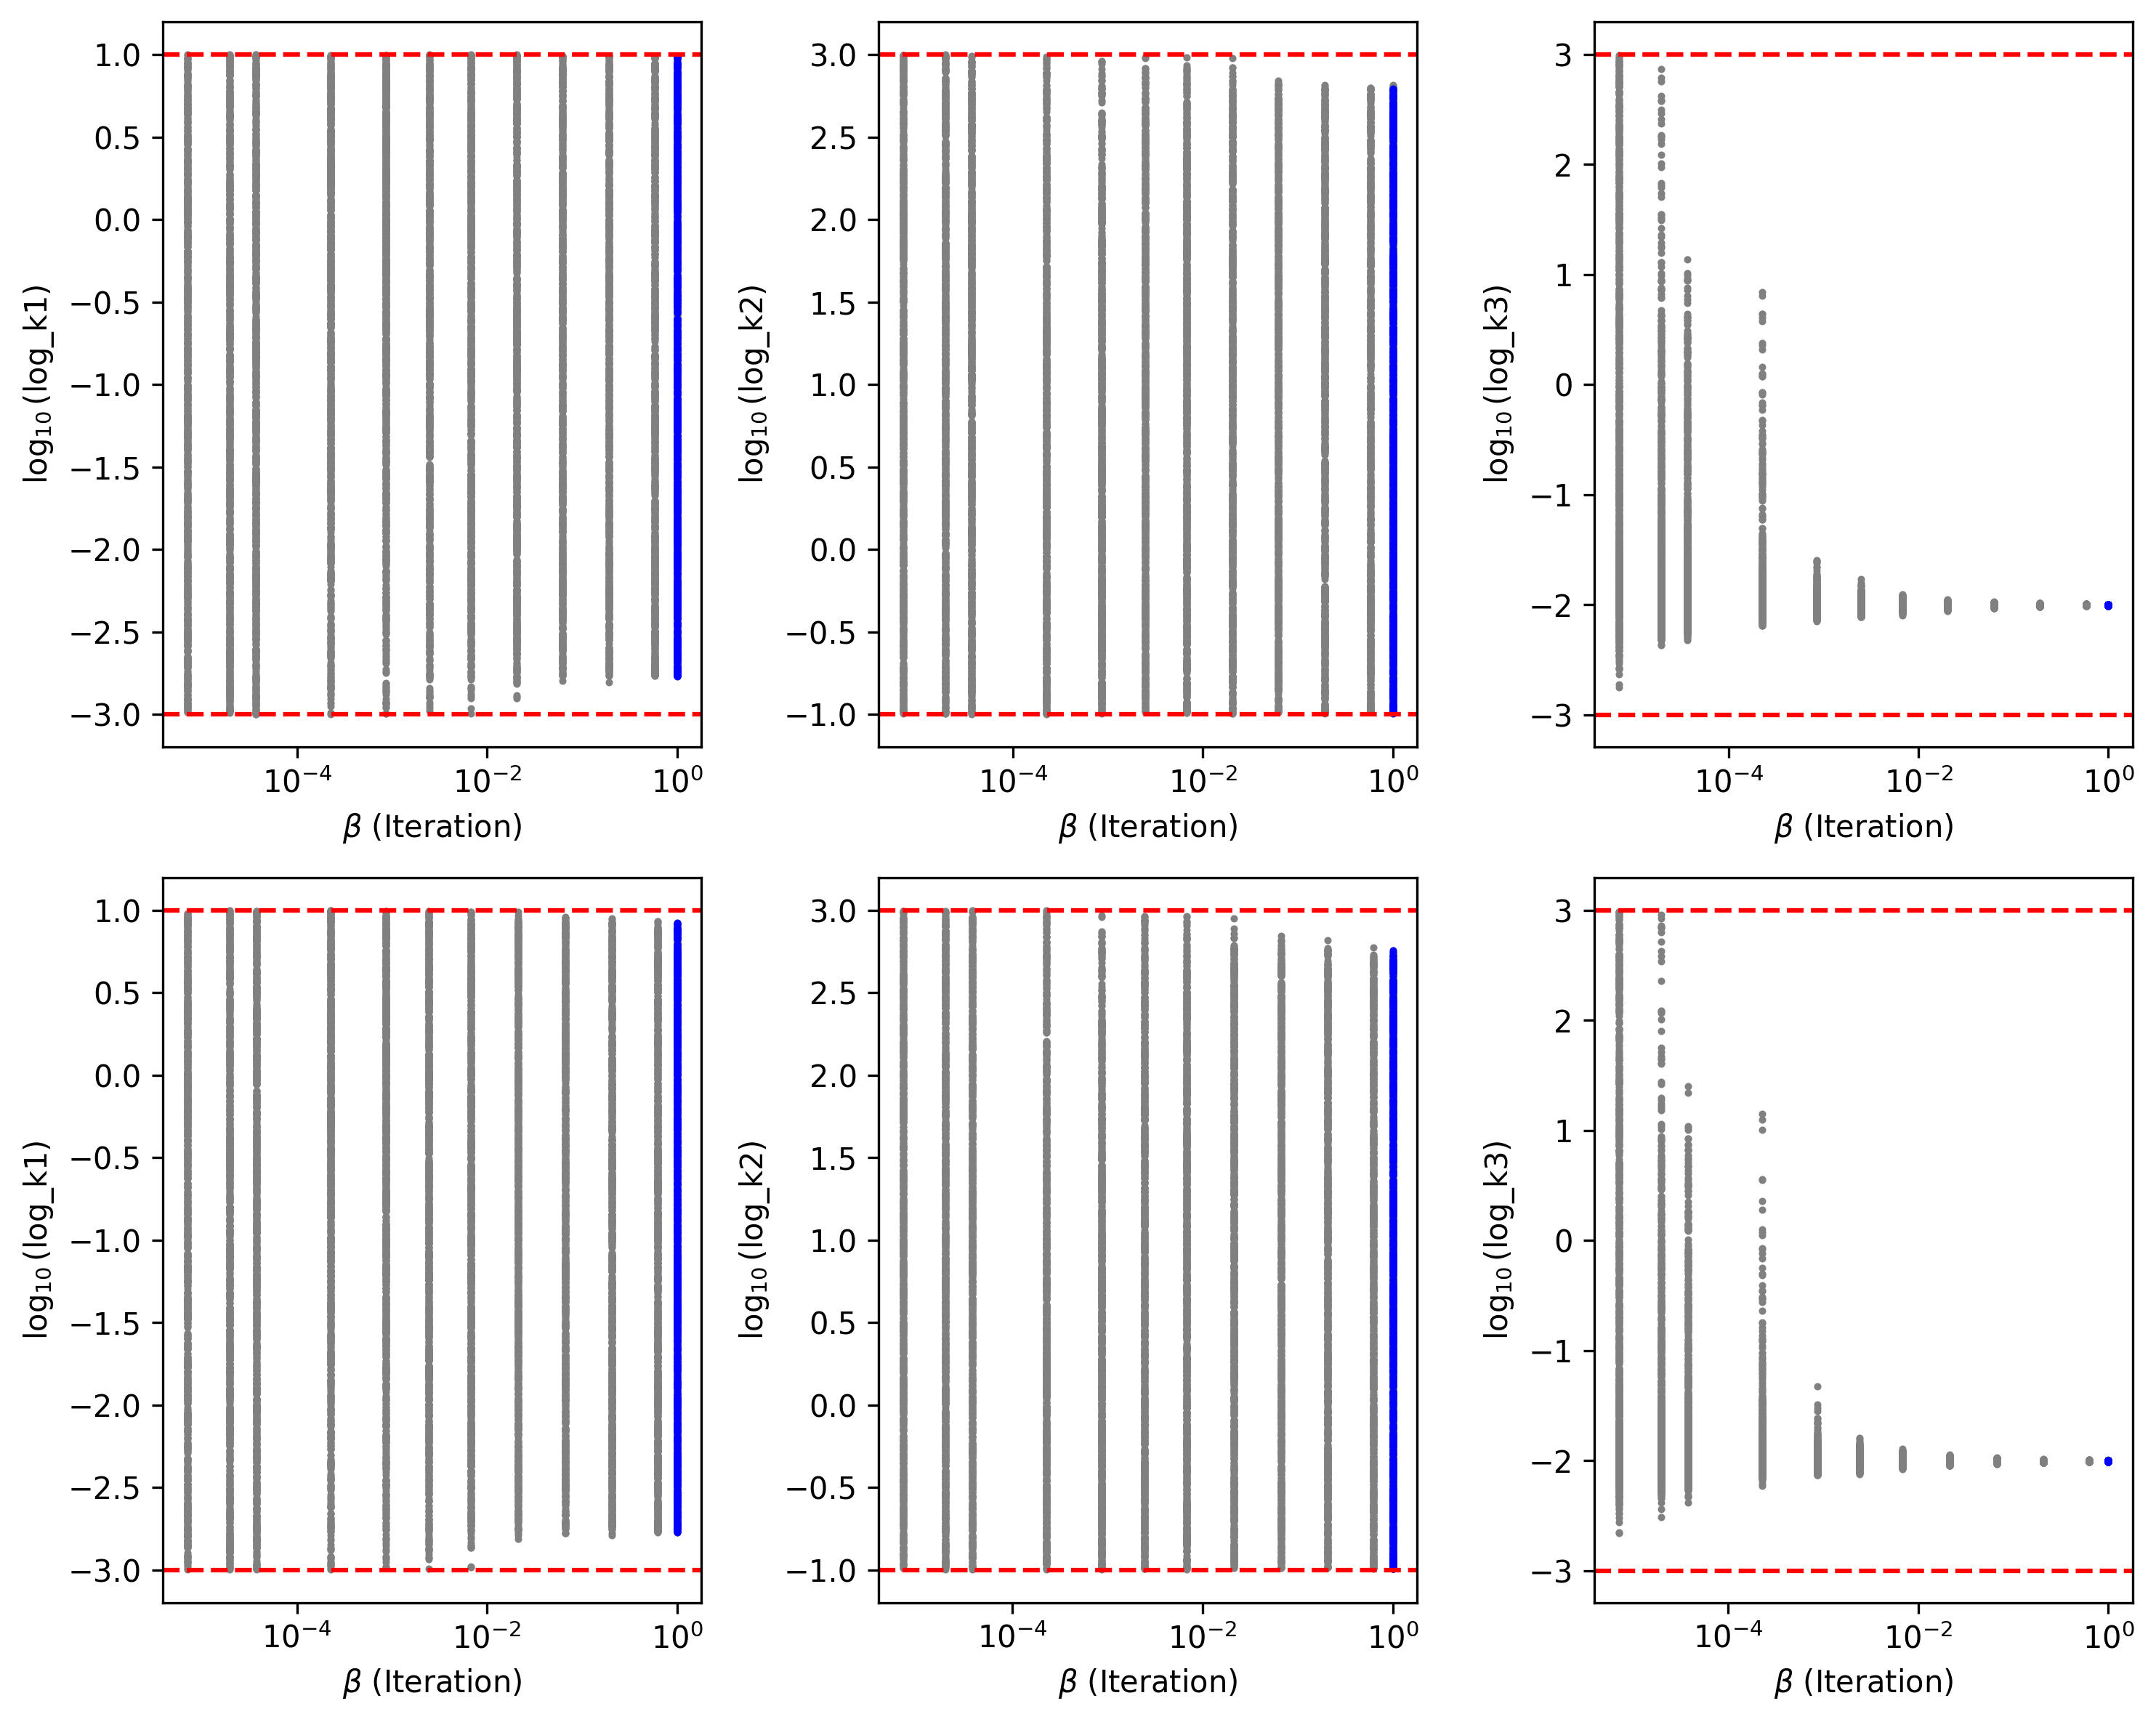

In [30]:
# Get the names of the estimated parameters
fit_par_names = mod_prob.problem.x_names
par_bounds = mod_prob.bounds

plt.figure(figsize=(10,8), dpi=300)
fig_num = 1
for j in range(len(best_results)):
	for i, par_name in enumerate(fit_par_names):       
		cur_result = best_results[j]
		#print(f"{i}\t{cur_result.method}")
		#print(int(f"{len(best_results)}{mod_prob.n_dim}{fig_num}"))
		plt.subplot(int(f"{len(best_results)}{mod_prob.n_dim}{fig_num}"))
		fig_num+=1
		n_iters = cur_result.n_iter
		n_chains = cur_result.n_chains
		n_dim = len(fit_par_names)

		cur_weights = cur_result.all_weights
		cur_trace = cur_result.all_samples[:, :, i]
		iters = cur_result.iters


		# Left column -- beta plots
		for q, it in enumerate(iters):
			if cur_result.method == "ptmcmc":
				if q % 100 != 0:
					continue
			color='grey'
			if q == n_iters - 1:
				color='blue'
			plt.scatter(
				np.full(n_chains, it),
				cur_trace[q, :],
				s=2,
				c=color,
				#alpha=cur_weights[q, :]
			)
	
		# Plot bounds
		plt.axhline(y=par_bounds[i][0], color='r', linestyle='--')
		plt.axhline(y=par_bounds[i][1], color='r', linestyle='--')
		plt.ylabel("$\\log_{10}$(%s)"%par_name)
		if cur_result.method != "ptmcmc":
			plt.xscale('log')
			plt.xlabel(r'$\beta$ (Iteration)')
		else:
			plt.xlabel("Iteration Number")
plt.tight_layout()

In [31]:
from pypesto.objective import AggregatedObjective
from pypesto.objective.roadrunner.road_runner import RoadRunnerObjective
obj = mod_prob.problem.objective
# print(mod_prob.problem.objective.__dict__.keys())

if isinstance(obj, AggregatedObjective):
    subobjs = mod_prob.problem.objective.__dict__["_objectives"]
    for subobj in subobjs:
        if isinstance(subobj, RoadRunnerObjective):
            obj = subobj
        else:
            continue

0.0 	 0.0
105.93645711872678 	 106.97935339626821
209.33506280439778 	 211.15238815776334
308.9926911341016 	 311.1194315208134
402.59632623047247 	 404.71159667052007
485.4754755133637 	 487.49311734039884
549.0699593248921 	 551.526613151895
584.3313082922114 	 586.42212387092
596.4304245282216 	 597.3125691885042
599.2725554116155 	 599.5269730616155
599.8554071629159 	 599.9189288214042


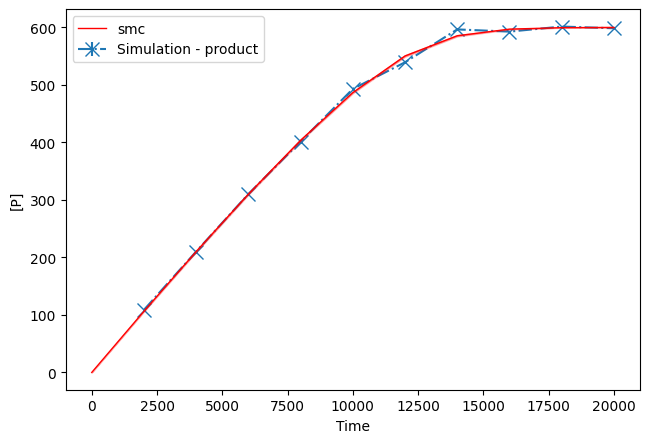

In [51]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)


petab_prob = mod_prob.petab_problem

ax_dict = plot_problem(petab_problem=petab_prob,) 
plot_keys = ax_dict.keys()
n_plots = len(plot_keys)
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(6,4)
for i, best in enumerate(best_results):
	pars = best.posterior_samples
	weights = best.posterior_weights

	all_sim_data = np.empty(shape=(n_plots, pars.shape[0]), dtype="object")

	## Collect all of the runs 
	for n, par in enumerate(pars):
		
		sim_dict = obj(par, mode="mode_fun", return_dict=True)["simulation_results"]
		sim_keys = sim_dict.keys()
		n_sims = len(sim_keys)
		
		assert n_plots == n_sims
		for j, (ax_key, sim_key) in enumerate(zip(plot_keys, sim_keys)):
			single_sim_data = sim_dict[sim_key]
			sim_ts = single_sim_data['time']
			n_specs = single_sim_data[:,1:].shape[1]
			data_to_add = single_sim_data[:, 1:]
			#print(data_to_add.shape)
			#if n_specs == 1:
			#	data_to_add.shape += (1,)
			#print(data_to_add.shape)
			all_sim_data[j, n] = data_to_add
	
	#print(all_sim_data.shape)
	# Calculate credible interval using weighted quantile function
	n_ts = len(sim_ts)
	#print(n_ts, n_specs)
	for q, ax_key in enumerate(plot_keys):
		low_sim_data = np.empty(shape=(n_ts, n_specs))
		high_sim_data = np.empty(shape=(n_ts, n_specs))
		mean_sim_data = np.empty(shape=(n_ts, n_specs))
		for s in range(n_specs):
			for t in range(n_ts):
				cur_data = all_sim_data[q, :]
				#print(cur_data.shape)
				cur_data = np.array([x[t, s] for x in cur_data])

				mean_sim_data[t, s] = np.average(cur_data, weights=weights)
				temp = weighted_quantile(cur_data, [LOWER_PCT, UPPER_PCT], weights)
				#print(temp[0])
				low_sim_data[t,s] = temp[0]
				high_sim_data[t,s] = temp[1]

			cur_ax = ax_dict[ax_key]
			cur_ax.plot(sim_ts, mean_sim_data[:, s], lw=1, label=best.method, zorder=3, color="r")
			cur_ax.fill_between(sim_ts, low_sim_data[:, s], high_sim_data[:, s], zorder=3, alpha=0.3, color="r")
			#for row in zip(low_sim_data[:,s], high_sim_data[:, s]):
			#	print(row[0], "\t", row[1])
			cur_ax.legend()